In [587]:
# from utils import solve_graph_weights, log2_comb, dig_sparse_level, MyNeighbour,comp_quant_encoding
from scipy.linalg import hadamard
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt
import networkx as net
import pandas as pd
import pickle
import itertools
from functools import partial
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit
import cvxpy as cvx
import plotly.express as pltly

In [588]:
np.set_printoptions(suppress = True)

parameters for $\mu-L$ convergence
* $\mu = \lambda$       regularization parameter

In [623]:
# Set distances among any pair of nodes
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = np.ones((K, K))
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
        
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
PL = A0 * ((D / d0) ** (-gamma))
# Generate per-iteration channels following Rayleigh fading
CH_gen = iter( np.random.randn(len(G.edges()),)/np.sqrt(2) + 1j * np.random.randn(len(G.edges()),)/np.sqrt(2) )
CH = np.ones((K, K), dtype=complex)  # Channel coefficients
for i in range(K):
    for j in G[i]:
        if j < i:
            CH[i, j] = next(CH_gen)
for i in range(K):
    for j in G[i]:
        if j > i:
            CH[i, j] = np.conjugate(CH[j, i])
CG = PL * (np.abs(CH)) ** 2 

In [592]:
# For an ER graph of connectivity probability of p = 0.20
# losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_eta0_2.00_zeta0_0.0010_rho_a_prime_100_10-0.pkl', 'rb') )
# losseses = np.array(losseses)
# K = losseses.shape[2]
# df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
opt = 0.41
losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_4_P_0.0002mW_N_7943_a_200.00_zeta0_0.0500(no_decay)_a_prime_1000.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_2_P_0.2000mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_2_P_0.0000mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0020_a_prime_100.00_ER.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_local_eta0_2.00.pkl', 'rb') )
losseses = np.array(losseses) - opt
df8 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

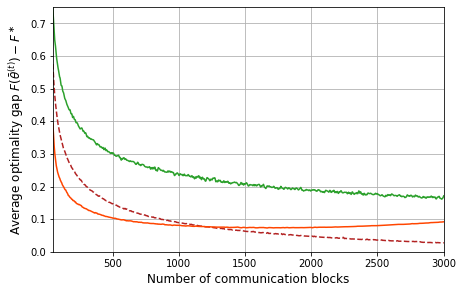

In [594]:
fig, ax = plt.subplots(figsize = (7.0,4.5))
df1.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'firebrick', label = r'Complete graph')
df2.rolling(window = 20).mean().mean(axis = 1).plot(color = 'orangered', label = r'2-D torus')
# df3.rolling(window = 20).mean().mean(axis = 1).plot(color = 'blueviolet', label = r'ER graph ($p=0.2$)')
# df4.rolling(window = 20).mean().mean(axis = 1).plot(color = 'saddlebrown', label = r'Complete graph')
# df5.rolling(window = 20).mean().mean(axis = 1).plot(color = 'teal', label = r'2-D torus')
# df6.rolling(window = 20).mean().mean(axis = 1).plot(color = 'tab:blue', label = r'ER graph ($p=0.2$)')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df8.rolling(window = 20).mean().mean(axis = 1).plot(color = 'tab:green', label = 'No commun.')

plt.xlabel(r'Number of communication blocks', fontsize = 12)
plt.ylabel(r'Average optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 12)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((50, 3000))
plt.ylim((0, 0.75))
plt.grid()
# plt.legend(loc = 'upper right', fontsize = 12)
# plt.savefig('C:/Users/Helen/documents/visiting_research@KCL/D2D_DSGD/repo_jv/fig/comp_loss_vs_commun_small_N.pdf',format='pdf', dpi=600)
plt.show()

In [590]:
df8.rolling(window = 20).mean().mean(axis = 1).min() + opt

0.5474595768004655

In [946]:
# For an ER graph of connectivity probability of p = 0.10 generated based on a STAR
# standard DSGD
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
losseses = np.array(losseses)
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# digital implementation of DSGD with the proposed scheduling
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_3_eta0_2.00_zeta0_0.1000_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# digital implementation of DSGD with TDMA
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_eta0_1.00_zeta0_0.0100_rho_a_5.0_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# analog implementation of DSGD with the sequential scheduling (obtain the smalliest #slots)
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_M_8_eta0_1.00_zeta0_0.0100_rho_a_5.0_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# analog implementation of DSGD with TDMA (obtain the largest #slots)
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_6_eta0_1.00_zeta0_0.0100_rho_a_5.0_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# independent training w/o communications
losseses = pickle.load( open('../repo_jv/data/losseses_local_eta0_2.00.pkl', 'rb') )
losseses = np.array(losseses)
df0 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

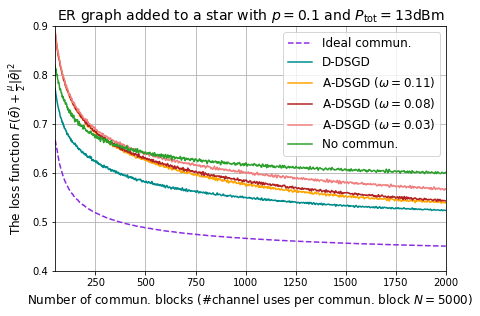

In [947]:
fig, ax = plt.subplots(figsize = (7.0,4.5))
df1.rolling(window = 5).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df5.rolling(window = 5).mean().mean(axis = 1).plot(color = 'darkcyan', label = 'D-DSGD')
df6.rolling(window = 5).mean().mean(axis = 1).plot(color = 'orange', label = r'A-DSGD ($\omega = 0.11$)')
df3.rolling(window = 5).mean().mean(axis = 1).plot(color = 'firebrick', label = r'A-DSGD ($\omega = 0.08$)')
df4.rolling(window = 5).mean().mean(axis = 1).plot(color = 'lightcoral', label = r'A-DSGD ($\omega = 0.03$)')
df0.rolling(window = 5).mean().mean(axis = 1).plot(color = 'tab:green', label = 'No commun.')

plt.xlabel(r'Number of commun. blocks (#channel uses per commun. block $N = 5000$)', fontsize = 12)
plt.ylabel(r'The loss function $F(\bar{\theta}) + \frac{\mu}{2}\|\bar{\theta}\|^2$', fontsize = 12)
plt.title(r'ER graph added to a star with $p = 0.1$ and $P_{\rm tot} = 13$dBm', fontsize = 14)
plt.xlim((50, 2000))
plt.ylim((0.4, 0.90))
plt.grid()

plt.legend(loc = 'upper right', fontsize = 12)
# plt.savefig('C:/Users/Helen/documents/visiting_research@KCL/D2D_DSGD/repo_jv/fig/comp_loss_vs_commun_star-based_med_N.pdf',format='pdf', dpi=600)
plt.show()

In [943]:
df6.rolling(window = 5).mean().mean(axis = 1).min()

0.538049122095108

In [832]:
import sys

In [7]:
5011.9 / 7850

0.6384585987261147

Generate a partial Hadamard matrix $H \in \{\pm 1\}^{m\times d}$

In [53]:
tilde_d = 2 ** 13
H = hadamard(tilde_d)
d = 7850
m = int(d / 1)
H_par = H[:m]

In [54]:
theta = np.random.randn(d,)
tilde_theta = np.concatenate((theta, np.zeros((2**13 - d,))), axis = 0)

In [55]:
n, p, tilde_d = 1, .5, 2 ** 13
r = np.random.binomial(n, p, (tilde_d,))
r[r == 0] = -1
temp = [H_par[i,:] * r for i in range(m)]
A = (1 / np.sqrt(m)) * np.array(temp)
est_theta = m/tilde_d * (A.T  @ (A @ tilde_theta))
est_theta = est_theta[:d]

In [59]:
(np.linalg.norm(est_theta - theta))**2 

268.0075239637175

In [60]:
(1 - m / tilde_d) * np.linalg.norm(theta)**2

327.9351916516721

In [162]:
g = net.Graph()

In [167]:
not G

False

Sequential scheduling on the connectivity graph $\mathcal{G}(\mathcal{V}, \mathcal{E})$

In [52]:
def TwoSectionH(G): # Generate the 2-section of the proposed hypergraph, i.e., H2
    # VertexH = G.nodes()
    Hyperedge = [ tuple(sorted([node] + [n for n in G.neighbors(node)])) 
                                    for node in G.nodes() ] # construct a hypergraph each of whose hyperedge consists of a node and its neighbours
    Hyperedge = list(set(Hyperedge)) # remove any repeated hyperedges
    H2Edges = [[tuple(sorted(e)) for e in net.complete_graph(he).edges()] for he in Hyperedge] # a list of list of edges of H2
    temp = [] # remove the inner list
    for e in H2Edges:
        temp.extend(e)
    H2Edges = list(set(temp)) # remove any repeated edges

    H2 = net.Graph()
    H2.add_nodes_from(G.nodes())
    H2.add_edges_from(H2Edges)
    vertex_color_map = net.greedy_color(H2, strategy = 'saturation_largest_first') # vertex coloring H2
    
    return H2, vertex_color_map

In [53]:
def seq_scheduling(G):
    # A sequential list (slot's) of star toplogy-based schedule in a form of dicts 
    Rx_schedule_list = [] 
    # key-value pair herein is node (n_b, n_c), where n_b is the #times for which a node transmits as a star center (BC), 
    # and n_c is the #times for which a node transmits to a star center
    Tx_times = {node:[0,0] for node in G.nodes()} 

    while G:
        _, from_node_to_color_id = TwoSectionH(G)
        color_degree = {c: sum( len(G[node]) for node, color in from_node_to_color_id.items() if color == c ) 
                             for c in from_node_to_color_id.values()}
        chosen_color = list(color_degree.values()).index(max(color_degree.values())) # find arg_max(degree(color_list))

        # A dict including (star center: associated nodes) pairs that transmits or recieves in parallel at the current slot
        Rx_schedule_dict = { node:G[node] for node, color in from_node_to_color_id.items() if color == chosen_color}
        # Append the scheule in the current slot to the sequential schedule list
        Rx_schedule_list.append(Rx_schedule_dict)
        # Update n_b for the star center
        for node in Rx_schedule_dict.keys():
            Tx_times[node][0] += 1
        # Update n_c for the neighbors of the star centers
        for neighbors in Rx_schedule_dict.values():
            for node in neighbors:
                Tx_times[node][1] += 1

        # Update the graph
        # Remove the scheduled Rxs, i.e., the star centers
        G.remove_nodes_from(Rx_schedule_dict.keys())
        # Remove any standalone nodes
        current_node_list = list(G.nodes())
        for node in current_node_list:
            if not(G[node]):
                G.remove_node(node)
   
    return Rx_schedule_list, Tx_times

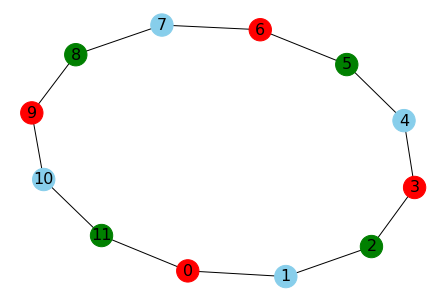

In [58]:
K = 12
seeds = iter(range(1000))
p = 0.2
#     ER = net.erdos_renyi_graph(K-1, .2, seed = next(seeds))
#     ER.add_node(K-1)
#     G = net.star_graph(reversed(range(K)))
#     G.add_edges_from(ER.edges())
# G = net.erdos_renyi_graph(K, p, seed = next(seeds))
G = net.cycle_graph(K)
pos = net.spring_layout(G)

color_list = ['red', 'skyblue', 'green', 'gold', 'm', 'magenta', 'darkorange', 'cyan','gray', 'pink', 
              'chocolate', 'turquoise', 'olive', 'blueviolet', 'lightgreen', 'brown', 'royalblue', 'limegreen', 
              'darkcyan', 'snow']
H2, from_node_to_color_id = TwoSectionH(G)
node_color_pairs = [ color_list[ from_node_to_color_id[node] ] for node in H2.nodes() ]
net.draw(G, pos, with_labels = True, node_color = node_color_pairs, node_size = 500, font_size = 16)

In [558]:
temp1 = G.copy()
schedule_list, Tx_times = seq_scheduling(temp1)
schedule_list

[{11: AtlasView({10: {}, 9: {}, 8: {}, 7: {}, 6: {}, 5: {}, 4: {}, 3: {}, 2: {}, 1: {}, 0: {}})},
 {6: AtlasView({8: {}, 4: {}, 5: {}}), 2: AtlasView({9: {}})},
 {9: AtlasView({8: {}})}]

In [573]:
Tx_times

{11: [1, 0],
 10: [0, 1],
 9: (1, 2),
 8: [0, 3],
 7: [0, 1],
 6: [1, 1],
 5: [0, 2],
 4: [0, 2],
 3: [0, 1],
 2: [1, 1],
 1: [0, 1],
 0: [0, 1]}

In [572]:
len(Rx_times)

12

In [569]:
Rx_times ={node:sum(Tx_times[node]) for node in G.nodes()}

In [592]:
bool(schedule_list[0].get(10))

False

In [544]:
temp2 = G.copy()
color_degree = {c: sum( len(temp2[node]) for node, color in from_node_to_color_id.items() if color == c ) 
                     for c in from_node_to_color_id.values()}
chosen_color = list(color_degree.values()).index(max(color_degree.values())) # find arg_max(degree(color_list))

# A dict including (star center: associated nodes) pairs that transmits or recieves in parallel at the current slot
Rx_schedule_dict = { node:temp2[node] for node, color in from_node_to_color_id.items() if color == chosen_color}
Rx_schedule_dict

{11: AtlasView({10: {}, 9: {}, 8: {}, 7: {}, 6: {}, 5: {}, 4: {}, 3: {}, 2: {}, 1: {}, 0: {}})}

In [545]:
temp2.remove_nodes_from(Rx_schedule_dict.keys())
# Remove any standalone nodes
current_node_list = list(temp2.nodes())

False

In [548]:
temp2.remove_nodes_from([0,1,3,7,10])

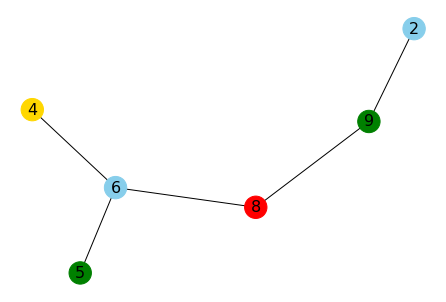

In [551]:
H2, from_node_to_color_id = TwoSectionH(temp2)
node_color_pairs = [ color_list[ from_node_to_color_id[node] ] for node in H2.nodes() ]
net.draw(temp2, pos, with_labels = True, node_color = node_color_pairs, node_size = 500, font_size = 16)

In [552]:
color_degree = {c: sum( len(temp2[node]) for node, color in from_node_to_color_id.items() if color == c ) 
                             for c in from_node_to_color_id.values()}
chosen_color = list(color_degree.values()).index(max(color_degree.values())) # find arg_max(degree(color_list))
chosen_color

1

In [553]:
Rx_schedule_dict = { node:G[node] for node, color in from_node_to_color_id.items() if color == chosen_color}

In [554]:
Rx_schedule_dict

{6: AtlasView({11: {}, 4: {}, 5: {}, 8: {}}), 2: AtlasView({11: {}, 9: {}})}

In [555]:
temp2.remove_nodes_from(Rx_schedule_dict.keys())

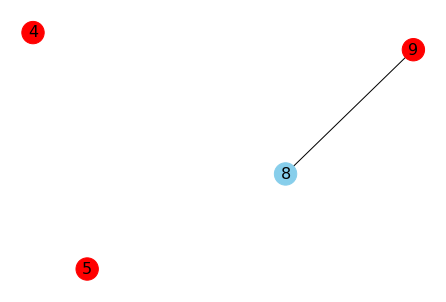

In [556]:
H2, from_node_to_color_id = TwoSectionH(temp2)
node_color_pairs = [ color_list[ from_node_to_color_id[node] ] for node in H2.nodes() ]
net.draw(temp2, pos, with_labels = True, node_color = node_color_pairs, node_size = 500, font_size = 16)

In [828]:
p = .1
ER = net.erdos_renyi_graph(K-1, p, seed = next(seeds))
Labels = net.relabel_nodes(ER, {node:node + 1 for node in ER.nodes()}, copy = False)
ER.add_node(0)
G = net.star_graph(K-1)
G.add_edges_from(ER.edges())

In [829]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [4]:
P_array = np.logspace(-2.7, 0, 6) 
normalized_P_array = P_array / .02
rho_a_prime_array = 10000 * normalized_P_array
" ".join( "{:.2f}".format(x) for x in rho_a_prime_array )

'997.63 3459.15 11994.16 41588.19 144201.58 500000.00'

In [5]:
P_array
" ".join( "{:.4f}".format(P) for P in P_array )

'0.0020 0.0069 0.0240 0.0832 0.2884 1.0000'

In [11]:
a_prime = rho_a_prime_array[0] / (1*1e4)
rho_array = rho_a_prime_array / a_prime
" ".join("{:.0f}".format(rho) for rho in rho_array)

'10000 34674 120226 416869 1445440 5011872'

In [49]:
N_array = np.linspace(785, 78500, 6)
N_array
" ".join( "{:d}".format(int(x)) for x in N_array )

'785 16328 31871 47414 62957 78500'

In [51]:
M = 5
(N_array / (2*M)) / d

array([0.01 , 0.208, 0.406, 0.604, 0.802, 1.   ])

**Visualize the distribution of the gradient**

In [24]:
grad_normses = pickle.load( open('../repo_jv/data/simulations/grad_normses_SCHEME_0.pkl', 'rb') )
grad_normses = np.array(grad_normses)

In [25]:
grad_normses = grad_normses.squeeze()

In [26]:
grad_normses.shape

(10000, 20)

(array([9762.,  147.,   36.,   14.,    8.,    5.,    3.,    3.,    3.,
           1.,    2.,    2.,    1.,    1.,    2.,    2.,    1.,    1.,
           4.,    2.]),
 array([0.0005576 , 0.00475812, 0.00895863, 0.01315914, 0.01735966,
        0.02156017, 0.02576068, 0.0299612 , 0.03416171, 0.03836223,
        0.04256274, 0.04676325, 0.05096377, 0.05516428, 0.05936479,
        0.06356531, 0.06776582, 0.07196634, 0.07616685, 0.08036736,
        0.08456788]),
 <a list of 20 Patch objects>)

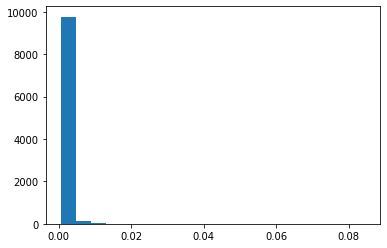

In [35]:
plt.hist(grad_normses[:,0], 20)

In [36]:
np.percentile(grad_normses, 95, axis=0).max()

0.003297388135488591

In [37]:
y = grad_normses.mean(axis=0)
yerr = grad_normses.std(axis=0)

In [38]:
(y+2*yerr).max()

0.011360729112263443

**The error bar** plots the range of data (y-yerr, y+yerr) with y connected for each column, while y and yerr are also specified by the users. For instance, for Gaussian RVs, "y" can be the mean value $\mu$, and "y_err" can be mulitples of standard derivation $\sigma$. 

<ErrorbarContainer object of 3 artists>

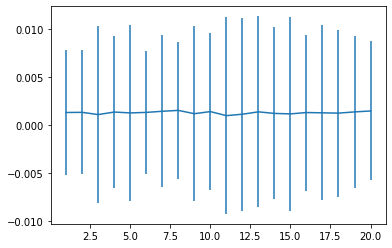

In [32]:
plt.errorbar(np.arange(1, 21), y, 2*yerr)

**The boxplot** plots the range of data with the whiskle ranging from 2.5-percentile to 97.5-percentile (i.e., 95% confidence interval) and the box rainging from 25% quantile to 75% quantile, respectively, while with the notch marking the median for each column of data. Note that if "bootstrap" is used, the 2.5- and 97.5-percentile of data are approximated by sampling the given data, otherwise $\sim\mathcal{N}(\mu,\sigma)$ is assumed to calculate the 2.5- and 97.5-percentile.

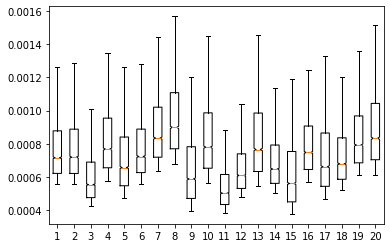

In [34]:
_=plt.boxplot(grad_normses[2000:], showfliers=False, notch=True, bootstrap = 1000)

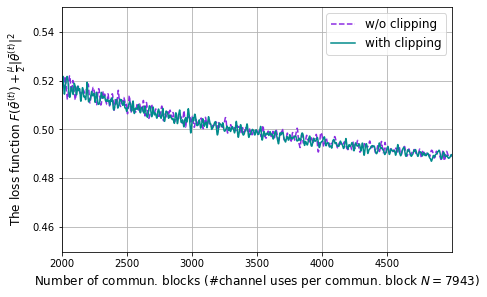

In [78]:
path='../repo_jv/data/simulations/'
losseses = pickle.load( open('{}losseses_SCHEME_5_P_0.0001_N_7943_rho_a_500.00_zeta0_0.0100_rho_a_prime_100.00.pkl'.format(path), 'rb') )
losseses = np.array(losseses).squeeze()
df = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('{}losseses_SCHEME_5_P_0.0001_N_7943_rho_a_500.00_zeta0_0.0100_rho_a_prime_100.00_with_clip.pkl'.format(path), 'rb') )
losseses = np.array(losseses).squeeze()
df_with_clip = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

fig, ax = plt.subplots(figsize = (7.0,4.5))
df.rolling(window = 5).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'w/o clipping')
df_with_clip.rolling(window = 5).mean().mean(axis = 1).plot(color = 'darkcyan', label = 'with clipping')

plt.xlabel(r'Number of commun. blocks (#channel uses per commun. block $N = 7943$)', fontsize = 12)
plt.ylabel(r'The loss function $F(\bar{\theta}^{(t)}) + \frac{\mu}{2}\|\bar{\theta}^{(t)}\|^2$', fontsize = 12)
# plt.title(r'ER graph added to a star with $p = 0.1$ and $P_{\rm tot} = 13$dBm', fontsize = 14)
plt.xlim((2000, 4999))
plt.ylim((0.45, 0.55))
plt.grid()

plt.legend(loc = 'upper right', fontsize = 12)
# plt.savefig('C:/Users/Helen/documents/visiting_research@KCL/D2D_DSGD/repo_jv/fig/comp_loss_vs_commun_star-based_med_N.pdf',format='pdf', dpi=600)
plt.show()